# 9 Detector Modelling

In [60]:
# to prepare the python environment

import numpy as np
import pandas as pd

from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

import pyradi.rydetector as rydetector
import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck


This notebook forms part of a series on computational optical radiometry
These notebooks are constantly revised and updated, please revisit from time to time.  

The source for this notebook is available at   
https://github.com/NelisW/ComputationalRadiometry/blob/master/09a-DetectorModelling.ipynb

The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

The pyradi rydetector  module models the primary functionality of optical detectors.  This notebook demonstrates the development of a simple single element InSb detector model suitable for high-level system modelling.  The performance of the detector is described in terms of its figures of merit. The theoretical background to this model is covered the text book.  

## Concept

The detector is modelled as a bulk material device, where a fraction of the incident photons are absorbed in the material and then converted to an electrical signal.  

## Analysis

### Detector material properties

Calculate the bandgap $E_g$ of the InSb material at the detector operating temperature (80 K), using 
(Eq 5.3) imlemented in rydetector.EgVarshni
$$
    E_g = E_{g}(0) -\left(\frac{A T^2}{T + B}\right).
$$ 

The Varshni model (Eq 5.3) is an approximated empirical fit to predict a semiconductor bandgap at a given temperature. The approximation employs three parameters: the reference bandgap at a
given temperature (usually 0 K), plus two parameters to predict the bandgap at other temperatures (relative to the reference bandgap). Several sets of different Varshni parameters were proposed (Table A.6) by Madelung, Piprek, and Dhanaraj, for the references see my book) using different reference bandgap values, and also based on different experimental data. The bandgap calculation considers three different sets of feasible Varshni coefficients.

The detector cutoff wavelength is calculated from $\lambda_c = 1.24/E_g$.

The data storage in the following cell is done in a Pandas dataframe, simply because it is easier to manipulate and display.  The detector parameters are entered as entries into the dataframe and then the Varshni equation is used to calculate Eg in a new row. Next the Eg values are used to calculate the cutoff wavelength $\lambda_c$.  All the data are neatly then displayed in the HTML table.

In [61]:
# to calculate the semiconductor properties
tempDet = 80  # detector temperature in K
varshni = pd.DataFrame({ 'Madelung' : pd.Series([0.24, 6e-4, 500, tempDet], index=['Eg(0)','A','B','T']),
           'Piprek' : pd.Series([0.235, 3.2e-4, 170, tempDet], index=['Eg(0)','A','B','T']),
           'Dhanaraj' : pd.Series([0.235, 3.1e-4, 452, tempDet], index=['Eg(0)','A','B','T'])})
eg = pd.DataFrame(varshni.apply(lambda x: rydetector.EgVarshni(x['Eg(0)'], x['A'], x['B'], x['T']), axis=0)).T
lambdaC = 1.24 / eg
varshni = pd.concat([varshni, eg], axis=0).rename({0:'Eg'})
varshni = pd.concat([varshni, lambdaC], axis=0).rename({0:'$\lambda_c$'})
Eg = varshni['Madelung']['Eg']
print("Madelung's value for Eg {} is used in the rest of this analysis.".format(Eg))
print("lambda_c is {}.".format(1.24/Eg))
varshni

Madelung's value for Eg 0.2333793103448276 is used in the rest of this analysis.
lambda_c is 5.3132387706855795.


,Madelung,Piprek,Dhanaraj
Eg(0),0.240000,0.235000,0.235000
A,0.000600,0.000320,0.000310
B,500.000000,170.000000,452.000000
T,80.000000,80.000000,80.000000
Eg,0.233379,0.226808,0.231271
$\lambda_c$,5.313239,5.467179,5.361683


The spectral absorption coefficient is calculated by using (Eq 5.78) and (Eq 5.79)

$$
\alpha_{\nu} \propto \sqrt{h\nu-E_g} \approx \alpha_{\lambda_c} +  \alpha_0\sqrt{h\nu-E_g} \;\; {\rm for} \;\; h\nu>E_g.
$$
and 
$$
\alpha_{\nu} = \alpha_{\lambda_c}\exp\left[\frac{h\nu-E_g}{kT}\right] \;\; {\rm for} \;\; h\nu<E_g.
$$
the data in (Table A.6). 

The quantum efficiency is calculated by using (Eq 5.87 and 5.88)
$$
\frac{J}{q E_q}=\eta=(1-\rho)(1-e^{- \alpha d})
$$
and
$$
\rho=
\left(
\frac{n_2-n_1}{n_2+n_1}
\right)^2,
$$
with a refractive index of 3.42 for the detector and 1.0 for air, a depletion layer thickness of 5 $\mu$m, and the spectral absorption coefficient calculated above. 

The spectral responsivity is calculated using the spectral quantum efficiency and (Eq. 5.5)
$$
{\cal R}_{e\lambda}
=\frac{i_d}{\Phi_{e}} 
= \frac{i_d}{\frac{hc}{\lambda}\Phi_{q}}
=\left\{
\begin{array}{ll}
\frac{\eta q\lambda G}{hc}
&{\rm for\ \ } \lambda \leq \lambda_c\\
0.0
&{\rm for\ \ } \lambda >\lambda_c\\
\end{array}
\right.
$$
The gain of the photovoltaic detector is 1.0. 

In [62]:
# to define detector parameters
# wavelength in micrometers, remember to scale down in functions.
wavelength = np.linspace(1, 5.5, 200)    

a0 = 1.9e4 * 100   # absorption coefficient [m-1], Eq3.5 & 3.6 Dereniak
a0p = 800 * 100    # absorption coefficient [m-1] Eq3.5 & 3.6 Dereniak
d1 = 0                # start of the detector depletion layer in meter
d2 = 5e-6             # end of the detector depletion layer in meter
n1 = 1.0              # refraction index of the air
n2 = 3.42        # refraction index of the semiconductor being analyzed
theta1 = 0.0        # radiation incident angle in radians

absorption = rydetector.Absorption(wavelength / 1e6, Eg, tempDet, a0, a0p)
quantumEffic = rydetector.QuantumEfficiency(absorption, d1, d2, theta1, n1, n2)
responsivity = rydetector.Responsivity(wavelength / 1e6,quantumEffic)

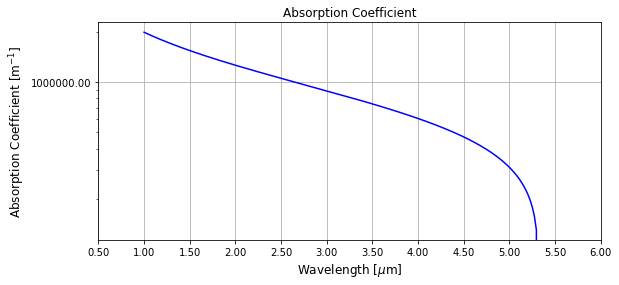

In [63]:
# to plot absorption coefficient
absFig = ryplot.Plotter(1,figsize=(9,4))
absFig.semilogY(1,wavelength,absorption,'Absorption Coefficient',\
    r'Wavelength [$\mu$m]',r'Absorption Coefficient [m$^{-1}$]');

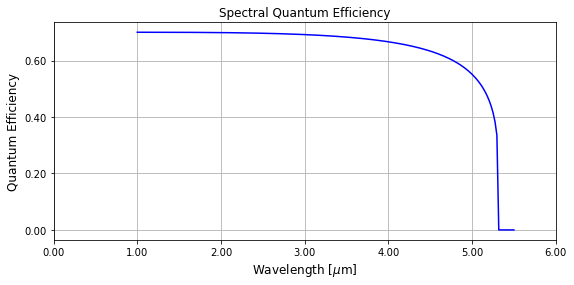

In [64]:
# to plot quantum efficiency
QE = ryplot.Plotter(1,figsize=(9,4))
QE.plot(1,wavelength,quantumEffic,'Spectral Quantum Efficiency',\
    r'Wavelength [$\mu$m]','Quantum Efficiency');

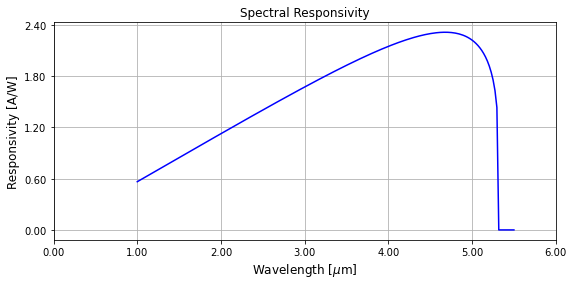

In [65]:
# to plot spectral response
Respons = ryplot.Plotter(1,figsize=(9,4))
Respons.plot(1,wavelength,responsivity,'Spectral Responsivity',\
    r'Wavelength [$\mu$m]','Responsivity [A/W]');

Calculate the spectral photon and radiant irradiance on the detector for a test source blackbody source with unity emissivity and temperature $T_s = 2000$ K.  The source area $A_s = 33$ mm$^2$, located a distance $R = 100$ mm from the detector. The irradiance is calculated as 
$$
E_{s\lambda}=\epsilon_{\lambda} M_\lambda(T_s)\omega/\pi=M(T_s)A_s/(\pi R^2),
$$
where the spectral exitance is given by (Eq. 3.1 and 3.3) for radiant and photon exitance, respectively.
$$
M_{e\lambda}(T)
=\frac{2\pi h c^2}{\lambda^5 \left(e^{hc/(\lambda kT)}-1\right)} 
=\frac{c_{1e\lambda}}{\lambda^5 \left(e^{c_{2\lambda}/(\lambda T)}-1\right)}
$$
and
$$
M_{q\lambda}(T)
=\frac{2\pi c}{\lambda^4 \left(e^{hc/(\lambda kT)}-1\right)}
=\frac{c_{1q\lambda}}{\lambda^4 \left(e^{c_{2\lambda}/(\lambda T)}-1\right)}
$$

In [66]:
# to prepare for detector signal current calculation
tempSource = 2000       # source temperature in K
emisSource = 1.0          # source emissivity
distance = 0.1      # distance between source and detector
areaSource = 0.000033     # source area in m2
solidAngSource = areaSource / (distance ** 2)
print ("Source temperature             = {0} K".format(tempSource))
print ("Source emissivity              = {0} ".format(emisSource))
print ("Source distance                = {0} m".format(distance))
print ("Source area                    = {0} m2".format(areaSource))
print ("Source solid angle             = {0} sr".format(solidAngSource))
EsourceQL =(emisSource * ryplanck.planck(wavelength,tempSource,'ql') \
    * solidAngSource) / (np.pi )
EsourceEL = (emisSource * ryplanck.planck(wavelength, tempSource,'el')*\
    solidAngSource) / (np.pi )


Source temperature             = 2000 K
Source emissivity              = 1.0 
Source distance                = 0.1 m
Source area                    = 3.3e-05 m2
Source solid angle             = 0.0032999999999999995 sr


Calculate the spectral photon and radiant irradiance on the detector for a hemispherical background blackbody source with unity emissivity and temperature of 280 K.  The calculation is done as above but for an hemispherical solid angle.

In [67]:
# to prepare for detector background current calculation 
tempBkg = 280.0              # background temperature in K
emisBkg = 1.0                # background emissivity
solidAngBkg = np.pi       # background is hemisphere

print ("Background temperature         = {0} K".format(tempBkg))
print ("Background emissivity          = {0} ".format(emisBkg))
print ("Background solid angle         = {0} sr".format(solidAngBkg))

#spectral irradiance for test setup, for both source and background
# in units of photon rate q/(s.m2)
EbkgQL = (emisBkg * ryplanck.planck(wavelength, tempBkg, 'ql') * \
    solidAngBkg ) / (np.pi )
#in radiant units W/m2
EbkgEL = (emisBkg * ryplanck.planck(wavelength, tempBkg, 'el') * \
    solidAngBkg) / (np.pi )


Background temperature         = 280.0 K
Background emissivity          = 1.0 
Background solid angle         = 3.141592653589793 sr


Calculate the current through the detector for source and background irradiance using a simplified version of (Eq. 6.17):
$$
 i_{\cal R}=
A_{d} \widehat{\cal R}
\int_{0}^{\infty} E_{s\lambda}{\cal R}_\lambda\,
d\lambda,
$$
using the spectral responsivity calculated  above.  The following calculation is performed for both the radiant irradiance and photon irradiance, and should yield the same resulting current.

The detector area is 200 $\mu$m by 200 $\mu$m.

In [68]:
# to calculate the detector currents
import scipy.constants as const
areaDet = (200e-6) ** 2   # detector area in m2

iSourceE = np.trapz(EsourceEL * areaDet * responsivity, wavelength)
iBkgE = np.trapz(EbkgEL * areaDet * responsivity, wavelength)
iSourceQ = np.trapz(EsourceQL * areaDet * quantumEffic * const.e,wavelength)
iBkgQ = np.trapz(EbkgQL * areaDet * quantumEffic * const.e, wavelength)
iTotalE = iSourceE + iBkgE
iTotalQ = iSourceQ + iBkgQ

print ("\nDetector current source        = {0:.3e} A and {1:.3e} A".\
    format(iSourceQ,iSourceE))
print ("Detector current background    = {0:.3e} A and {1:.3e} A".\
    format(iBkgQ,iBkgE))
print ("Detector current total         = {0:.3e} A and {1:.3e} A".\
    format(iTotalQ,iTotalE))


Detector current source        = 4.120e-05 A and 4.120e-05 A
Detector current background    = 3.588e-07 A and 3.588e-07 A
Detector current total         = 4.155e-05 A and 4.155e-05 A


Calculate the detector reverse saturation current $I_{\rm sat}$. First, calculate the carrier diffusion lengths $L_e$ and $L_h$ by using (Eq. 5.125 and 5.126)

$$
L_h = \sqrt{kT\mu_h \tau_h/q}
$$
and
$$
L_e = \sqrt{kT\mu_e \tau_e/q}
$$
Second, calculate the intrinsic carrier concentration $n_i$ using (Eq. 5.74)
$$
n_i^2 = n p = 4 \left(\frac{2\pi k T}{h^2}\right)^3 \exp\left[\frac{-E_g}{kT}\right]\left(m^*_h m^*_e\right)^{3/2}
$$
The donor concentration is calculated using (Eq. 5.76 and 5.77)
$$
p_n = n^2_i/n_n = n^2_i/n_d.
$$
and 
$$
n_p = n^2_i/p_p = n^2_i/n_a.
$$
to determine the concentration of carriers.
Finally, calculate the reverse-saturation current with (Eq. 5.131)
$$
I_{\rm sat}=q A_d \left(
\frac{n_i^2 L_e}{n_a \tau_e} +    \frac{n_i^2 L_h}{n_d \tau_h}
\right)
$$ 

The values used in this calculation for the InSb detector are as follows:
electron mobility 100.0 cm$^2$/(V$\cdot$s);
electron lifetime  $1\times10^{-8}$ s;
hole mobility  1.0  cm$^2$/(V$\cdot$s);
hole lifetime  $1\times10^{-8}$ s;
electron effective mass 0.014 of electron mass;
hole effective mass 0.43 of electron mass;
acceptor concentration $1\times10^{16}$ m$^{-3}$;
donor concentration $1\times10^{16}$ m$^{-3}$;
$E_g$ as calculated  above; and 
detector temperature of 80 K. 


In [69]:
# to calculate the reverse saturation current
eMob = 100.0    # electron mobility - m2/V.s
hMob = 1.0    # hole mobility - m2/V.s
tauE = 1e-8    # electron lifetime - s
tauH = 1e-8    # electron lifetime - s
me = 0.014 * const.m_e    # electron effective mass
mh = 0.43 * const.m_e     # hole effective mass
na = 1e16        # doping = acceptor concentration - m-3
nd = 1e16        # doping = donor concentration - m-3
Isat,ni = rydetector.Isaturation(eMob, tauE, hMob, tauH, me, 
                                 mh, na, nd, Eg, tempDet, areaDet)
print ("I0               = {0} [A] ".format(Isat))
print ("ni               = {0} [m-3] ".format(ni))

I0               = 6.480223667228038e-08 [A] 
ni               = 3327344312803649.5 [m-3] 


Calculate the current-voltage relationship using (Eq 5.128)
$$
I=
I_{\rm sat}
e^{qV/(kT\beta)}
-
I_{\rm sat}
 -I_{ph},
$$

The saturation current $I_{\rm sat}$ is calculated as explained  above.  The photocurrent is determined from (Eq. 5.4 and 5.5)

$$
{\cal R}_{q\lambda}=\frac{i_d}{\Phi_{q}} 
=\left\{\begin{array}{ll}
\eta q G
&{\rm for\ \ } \lambda \leq \lambda_c\\
0.0
&{\rm for\ \ } \lambda >\lambda_c\\
\end{array},
\right. 
$$
and 
$$
{\cal R}_{e\lambda}
=\frac{i_d}{\Phi_{e}} 
= \frac{i_d}{\frac{hc}{\lambda}\Phi_{q}}
=\left\{
\begin{array}{ll}
\frac{\eta q\lambda G}{hc}
&{\rm for\ \ } \lambda \leq \lambda_c\\
0.0
&{\rm for\ \ } \lambda >\lambda_c\\
\end{array}
\right.
$$

The value of $\beta$ is determined as explained in (Sec. 5.9.2).  The value for $\beta=1.7$ is used here because InSb operation is dominated by g-r current (for references see my book).

The current-voltage relationship can be calculated for different background flux values, such as 'dark' ($I_{ph}=0$), or for different irradiance values, such as those calculated above.

The following figure shows the current-voltage relationship for three cases: (a) the dark current (i.e., no background flux), (b) hemispherical background flux at 280 K, and (c) the test source flux.  

Note that the y axis is logarithmic to show detail: *negative values are shown positive because the logarithm of a negative number is not defined*.

Note that the dark current I-V curve is close to the background current I-V curve, while the test source curve is shifted down by almost two orders of magnitude; this is caused by the photon current resulting from the test source flux.

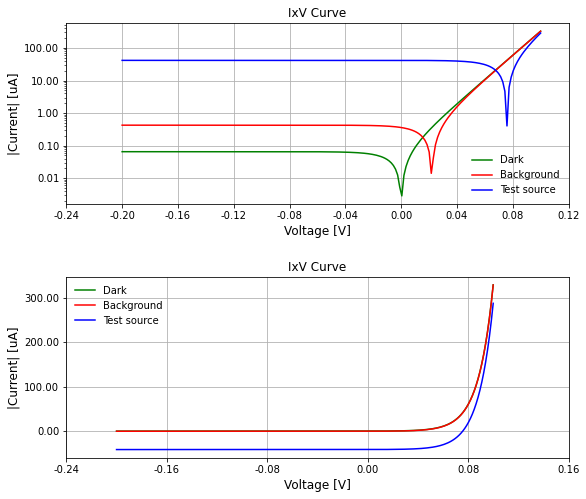

In [70]:
# to plot the IV curves
IVbeta = 1.7     # 1 = dominanr diffusion current, 2 = g-r dominant
Vbias = np.linspace(-200e-3, 100e-3, 200) # bias voltage range
ixvDark = rydetector.IXV(Vbias, IVbeta, tempDet, 0, Isat)
ixvBackgnd = rydetector.IXV(Vbias, IVbeta, tempDet, iBkgE, Isat)
ixvTotalE = rydetector.IXV(Vbias, IVbeta, tempDet, iTotalE, Isat)
IXVplot = ryplot.Plotter(1,2,1,figsize=(9,8))
IXVplot.semilogY(1,Vbias,np.abs(ixvDark) * 1e6, plotCol=['g'],label=['Dark'])
IXVplot.semilogY(1,Vbias,np.abs(ixvBackgnd) * 1e6, plotCol=['r'],label=['Background'])
IXVplot.semilogY(1,Vbias,np.abs(ixvTotalE) * 1e6,'IxV Curve',\
    'Voltage [V]','|Current| [uA]',plotCol=['b'],label=['Test source'])
IXVplot.plot(2,Vbias,ixvDark * 1e6, plotCol=['g'],label=['Dark'])
IXVplot.plot(2,Vbias,ixvBackgnd * 1e6, plotCol=['r'],label=['Background'])
IXVplot.plot(2,Vbias,ixvTotalE * 1e6,'IxV Curve',\
    'Voltage [V]','|Current| [uA]',plotCol=['b'],label=['Test source']);

(Eq. 5.140) is used to calculate the detector's dynamic resistance under zero-bias voltage, 
$$
R_0=-\left.\left(\frac{dI}{dV}\right)^{-1}\right\vert_{V=0} = \frac{\beta k T}{q I_{\rm sat}}
$$
 using the reverse-saturation current calculated  above.
 
The Johnson noise is calculated using (Eq 5.141) 
$$
i_n^2 
= \frac{4kT}{R_0}
=\frac{4q I_{\rm sat}}{\beta }
=\frac{2(2q I_{\rm sat})}{\beta },
$$

The noise PSD for the three current components: (a) diffusion, (b) thermal excitation, and (c) photocurrent is calculated using (Eq. 5.143).
$$
i^2_n=2q  I_{\rm sat} e^{qV/(kT\beta)}  + 2q  I_{\rm sat}  + 2q   I_{ph}
$$

The total noise is found by adding all four components in quadrature.

In [71]:
# to calculate R0A product
deltaFreq = 100.0      # measurement or desirable bandwidth - Hertz
iNoisePsd, R0, johnsonPsd, shotPsd = rydetector.Noise(tempDet, IVbeta, Isat, iBkgE)
iNoise = iNoisePsd * np.sqrt(deltaFreq)

print('R0=              = {0} Ohm'.format(R0))
print('NBW=             = {0} Hz'.format(deltaFreq))
print("iNoiseTotal      = {0} A".format(iNoise))
print("iNoise Johnson=  = {0} A".format(johnsonPsd * np.sqrt(deltaFreq)))
print("iNoise shot      = {0} A".format(shotPsd * np.sqrt(deltaFreq)))

R0=              = 180851.36930976599 Ohm
NBW=             = 100.0 Hz
iNoiseTotal      = 4.253495459385366e-12 A
iNoise Johnson=  = 1.5629883099729602e-12 A
iNoise shot      = 3.955918498389444e-12 A


The NEP is determined from  (Eq. 5.25)
$$
{NEP}_\lambda=\frac{i_d \sqrt{\Delta{}f}}{{\cal R}_\lambda}
$$
with the spectral responsivity calculated and the noise current calculated above.  The NEP is calculated and shown next.

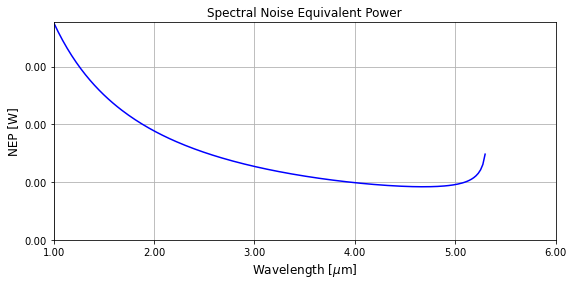

In [72]:
# to calculate NEP
NEPower, detectivity = rydetector.NEP(iNoise, responsivity)
NEPfig = ryplot.Plotter(1,figsize=(9,4))
NEPfig.plot(1,wavelength,NEPower,'Spectral Noise Equivalent Power',\
    r'Wavelength [$\mu$m]','NEP [W]',\
    pltaxis=[np.min(wavelength), np.max(wavelength), 0,NEPower[0]]);

The $D^\ast$ is calculated from the area of the detector, the noise bandwidth, the noise, and the responsivity, by (Eq. 5.26)
$$
D^\ast_\lambda
=\frac{\sqrt{\Delta{}f A_d}}{{NEP}_\lambda}
=\frac{{\cal R}_\lambda \sqrt{\Delta{}f A_d} }{i_d \sqrt{\Delta{}f}  }
$$

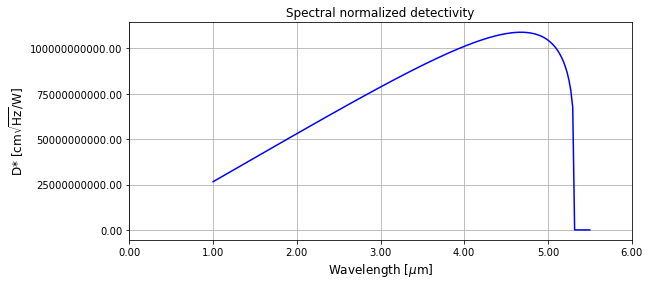

In [73]:
# to calculate Dstar
#use either of the following two forms:
#dStar = rydetector.DStar(areaDet, deltaFreq, iNoise, responsivity) # units in cm
dStar = rydetector.DStar(areaDet, 1, iNoisePsd, responsivity) # units in cm

DStarfig = ryplot.Plotter(1,figsize=(9,4))
DStarfig.plot(1,wavelength,dStar,'Spectral normalized detectivity',\
    r'Wavelength [$\mu$m]',r'D* [cm$\sqrt{{\rm Hz}}$/W]');

## Python and module versions, and dates

In [74]:
# to plot software versions
# https://github.com/rasbt/watermark
try:
    import pyradi.ryutils as ryutils
    print(ryutils.VersionInformation('matplotlib,numpy,pyradi,scipy,pandas'))
except:
    print("pyradi.ryutils not found")

Software versions
Python:   3.8.3 64bit [MSC v.1916 64 bit (AMD64)]
IPython:   7.30.1
OS:   Windows 10 10.0.19041 SP0
matplotlib:   3.5.1
numpy:   1.20.3
pyradi:   1.1.4
scipy:   1.7.3
pandas:   1.3.5
Mon Jan 10 16:55:04 2022 South Africa Standard Time
